In [174]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from generate_data import FMCODES

In [175]:
# Get vocabulary size
def get_vocab_size(observations):
    """ Get the vocabulary size of the generated observations. """
    all_obs = ' '.join(observations)
    tokens = word_tokenize(all_obs)
    vocab_size = len(set(tokens))
    return vocab_size

# Measure the lexical diversity of the generated observations
def measure_diversity(observations):
    """ Measure the lexical diversity of the generated observations."""
    all_obs = ' '.join(observations)
    tokens = word_tokenize(all_obs)
    fdist = FreqDist(tokens)
    num_types = len(fdist)
    num_tokens = len(tokens)
    ttr = num_types / num_tokens
    guirauds_r = num_types / np.sqrt(num_tokens)
    herdans_c = np.log(num_types) / np.log(num_tokens)
    return round(ttr, 4), round(guirauds_r, 4), round(herdans_c, 4)

# Measure the similarity of the generated observations
def measure_similarity(observations):
    """ Measure the semantic similarity of the generated observations. """
    cosines, jaccards = [], []
    for i in range(len(observations)):
        for j in range(i + 1, len(observations)):
            phrase1 = observations[i]
            phrase2 = observations[j]
            
            # Cosine similarity
            vectorizer = CountVectorizer()
            X = vectorizer.fit_transform([phrase1, phrase2])
            cosine_sim = cosine_similarity(X)[0, 1]
            cosines.append(cosine_sim)
            
            # Jaccard similarity
            words1 = set(word_tokenize(phrase1.lower()))
            words2 = set(word_tokenize(phrase2.lower()))
            jaccard = len(words1.intersection(words2)) / len(words1.union(words2))
            jaccards.append(jaccard)
    return round(np.mean(cosines), 4), round(np.mean(jaccards), 4)

In [198]:
diversity = {}
similarity = {}
for code in FMCODES.values():
    filepath = os.path.join(f'LLM_observations/diversity/{code}.csv')
    with open(filepath, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        observations = [row[0] for row in reader]
    ttr, guirauds_r, herdans_c = measure_diversity(observations)
    diversity[code] = [ttr, guirauds_r, herdans_c]
    cosines, jaccards = measure_similarity(observations)
    similarity[code] = [cosines, jaccards]

In [203]:
# Measure Semantic Similarity
models = {
    "MiniScore2": "all-MiniLM-L6-v2",
    "MiniScore": "all-MiniLM-L12-v2",
    "MpnetScore": "all-mpnet-base-v2",
    "RobertaScore": "all-distilroberta-v1"
}
scores = {}
for code in FMCODES.values():
    scores[code] = []

for score_name, model_name in models.items():
    model = SentenceTransformer(model_name)
    for code in FMCODES.values():
        filepath = os.path.join(f'LLM_observations/diversity/{code}.csv')
        with open(filepath, 'r', encoding='utf-8') as file:
            reader = csv.reader(file)
            observations = [row[0] for row in reader]
        total = []
        embeddings = model.encode(observations)
        for i, emb1 in enumerate(embeddings):
            for emb2 in embeddings[i+1:]:
                current = cosine_similarity([emb1], [emb2])[0][0]
                total.append(current)
        overall_similarity = sum(total) / len(total)
        scores[code].append(round(overall_similarity, 4))

In [206]:
# Function to write scores to a CSV file
def write_scores_to_csv(scores, header, filename):
    with open(filename, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(header)
        for code, values in scores.items():
            writer.writerow([code] + values)
            
# Write diversity scores to a CSV file
columns_diversity = ['Code', 'TTR', 'Guirauds_R', 'Herdans_C']
diversity_file = os.path.join('metrics/diversity_scores.csv')
write_scores_to_csv(diversity, columns_diversity, diversity_file)
diversity_df = pd.read_csv(diversity_file)
diversity_df = diversity_df.sort_values(by='TTR')
diversity_df.reset_index(drop=True, inplace=True)

# Write similarity scores to a CSV file
columns_similarity = ['Code', 'Cosine_Similarity', 'Jaccard_Similarity']
similarity_file = os.path.join('metrics/similarity_scores.csv')
write_scores_to_csv(similarity, columns_similarity, similarity_file)
similarity_df = pd.read_csv(similarity_file)
similarity_df = similarity_df.sort_values(by='Cosine_Similarity')
similarity_df.reset_index(drop=True, inplace=True)

# Write semantic similarity scores to a CSV file
columns_semantic = ['Code', 'MiniScore2', 'MiniScore', 'MpnetScore', 'RobertaScore']
semantic_file = os.path.join('metrics/semantic_scores.csv')
write_scores_to_csv(scores, columns_semantic, semantic_file)
semantic_df = pd.read_csv(semantic_file)
semantic_df = semantic_df.sort_values(by='MiniScore2')
semantic_df.reset_index(drop=True, inplace=True)

In [208]:
# Function to calculate Spearman's rank correlation coefficient between two columns
def calculate_spearman_corr(df, column1, column2):
    """ Calculate Spearman's rank correlation coefficient. """
    spearman_corr = spearmanr(df[column1].rank(), df[column2].rank()).correlation
    return spearman_corr

# Function to calculate and print between all pairs of columns
def print_spearman_corr(df, columns):
    """ Print Spearman's rank correlation coefficient. """
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            column1 = columns[i]
            column2 = columns[j]
            spearman_corr = calculate_spearman_corr(df, column1, column2)
            print(f"{column1} vs {column2}: {spearman_corr}")    

# Sort the dataframes by each metric
df_sorted_diversity = pd.DataFrame({
    'TTR': diversity_df.sort_values('TTR')['Code'].tolist(),
    "Guirauds_R": diversity_df.sort_values("Guirauds_R")['Code'].tolist(),
    "Herdans_C": diversity_df.sort_values("Herdans_C")['Code'].tolist()
})
df_sorted_similarity = pd.DataFrame({
    'Cosine_Similarity': similarity_df.sort_values('Cosine_Similarity')['Code'].tolist(),
    "Jaccard_Similarity": similarity_df.sort_values("Jaccard_Similarity")['Code'].tolist(),
})
df_sorted_diversity.to_csv('metrics/diversity_sorted.csv', index=False)
df_sorted_similarity.to_csv('metrics/similarity_sorted.csv', index=False)

# Calculate and print correlations
print_spearman_corr(df_sorted_diversity, columns_diversity[1:])
print_spearman_corr(df_sorted_similarity, columns_similarity[1:])

TTR vs Guirauds_R: 0.13382269904009036
TTR vs Herdans_C: 0.2749858836815359
Guirauds_R vs Herdans_C: 0.032185206098249576
Cosine_Similarity vs Jaccard_Similarity: 0.9469226425748165


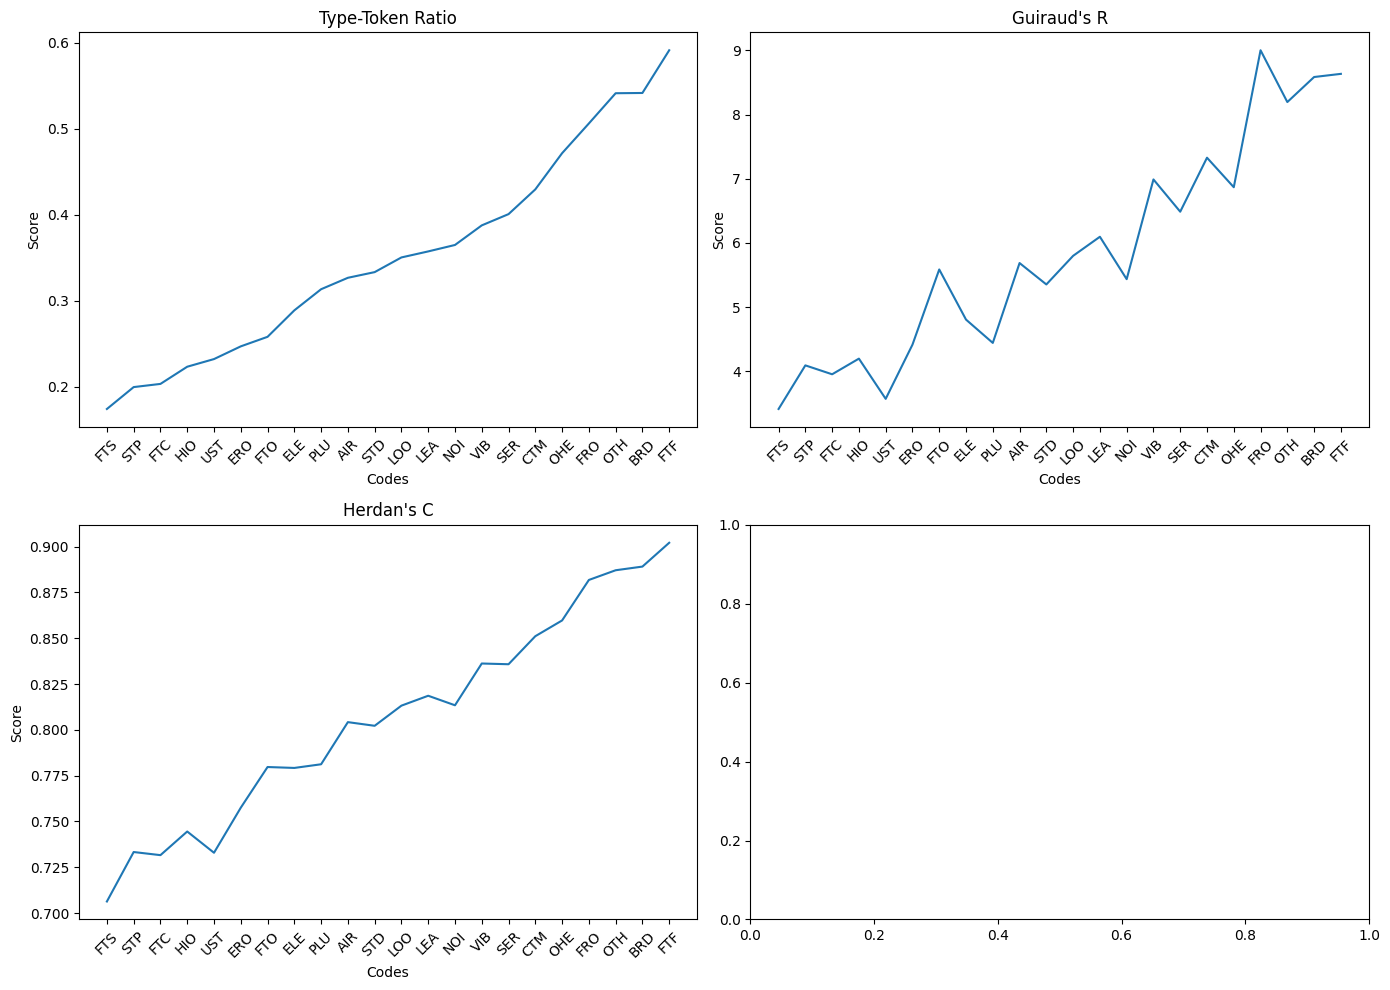

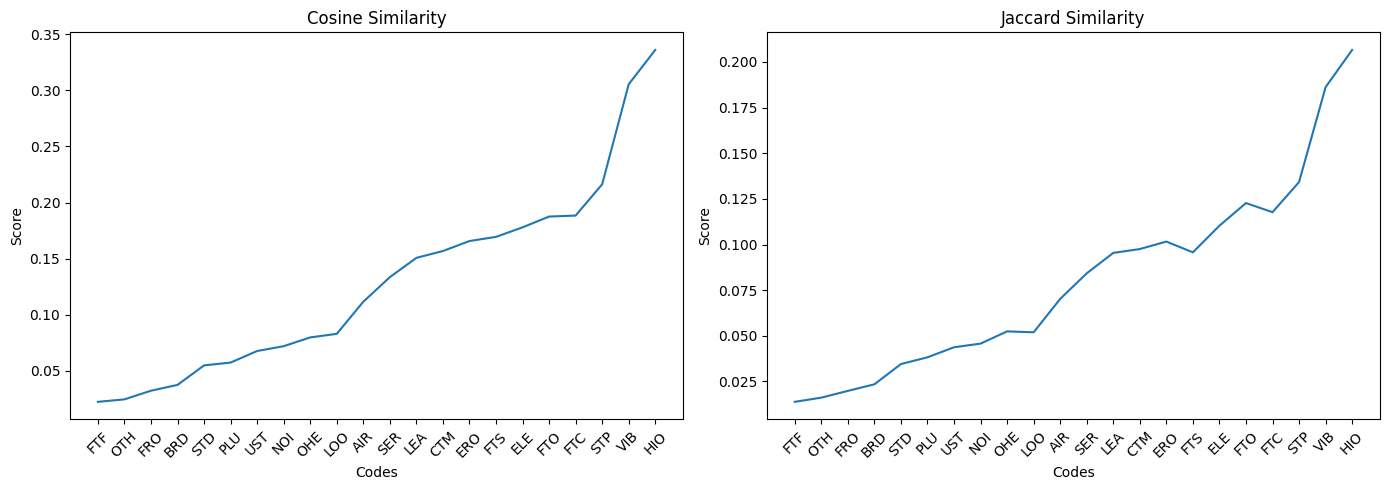

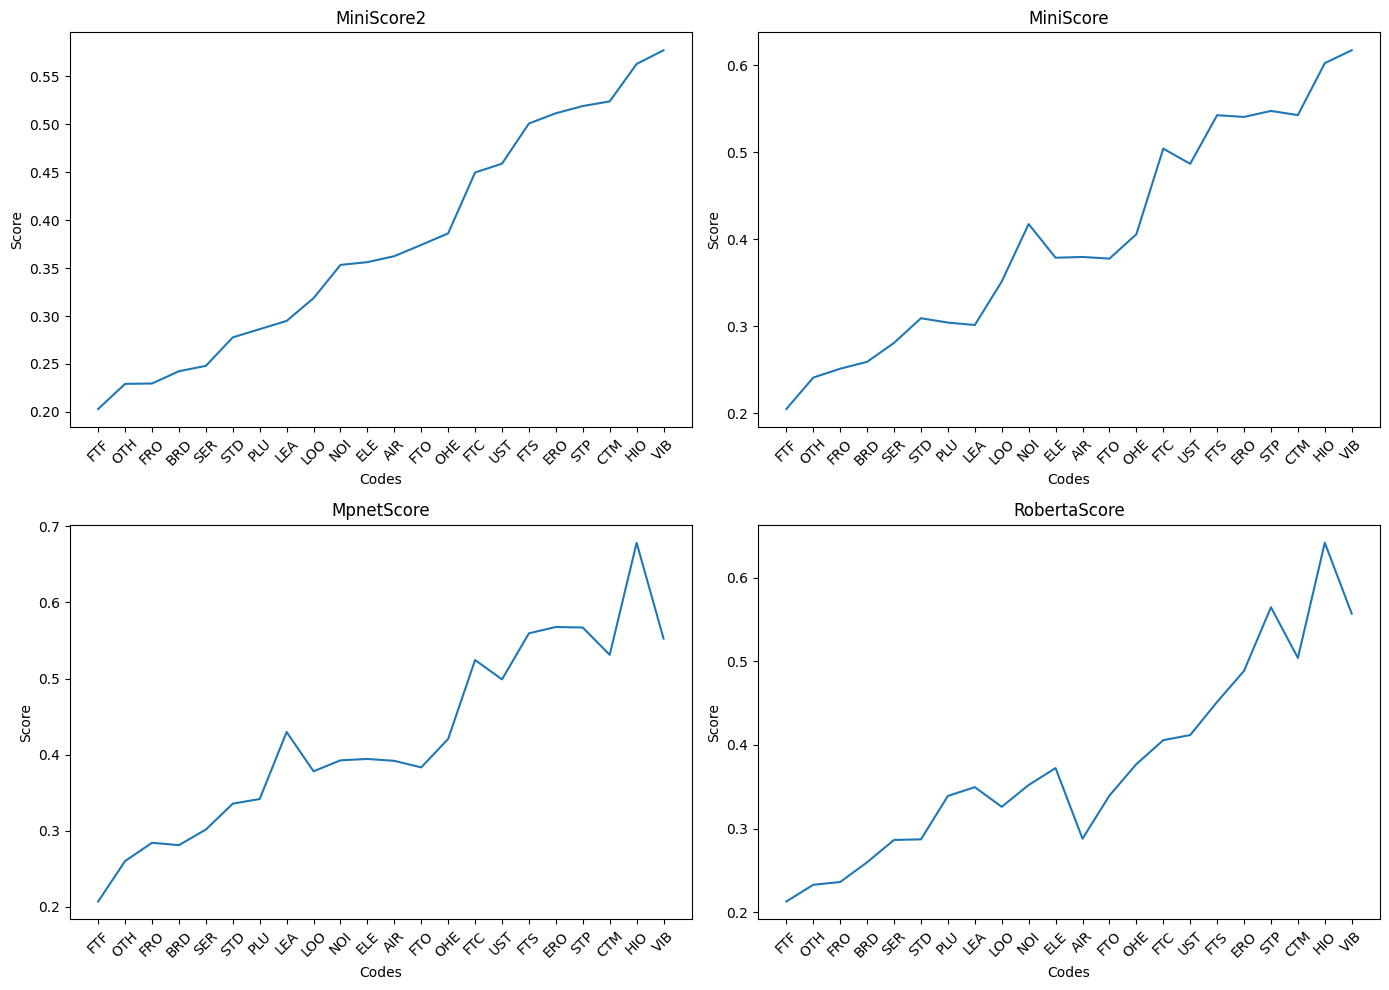

In [209]:
# Function to plot the scores for each metric
def plot_scores(df, columns, titles, figsize):
    """Plot scores for each column in the DataFrame."""
    num_plots = len(columns)
    num_rows = (num_plots + 1) // 2
    fig, axs = plt.subplots(num_rows, 2, figsize=figsize)
    for i, col in enumerate(columns):
        ax = axs[i // 2, i % 2] if num_rows > 1 else axs[i]
        ax.plot(df['Code'], df[col])
        ax.set_title(titles[i])
        ax.set_xlabel('Codes')
        ax.set_ylabel('Score')
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
    
diversity_titles = ['Type-Token Ratio', "Guiraud's R", "Herdan's C"]
plot_scores(diversity_df, columns_diversity[1:], diversity_titles, (14, 10))
similarity_titles = ['Cosine Similarity', 'Jaccard Similarity']
plot_scores(similarity_df, columns_similarity[1:], similarity_titles, (14, 5))
semantic_titles = ['MiniScore2', 'MiniScore', 'MpnetScore', 'RobertaScore']
plot_scores(semantic_df, columns_semantic[1:], semantic_titles, (14, 10))